## IMPORTAMOS LAS LIBRERIAS

In [ ]:
%%capture
from scipy.signal import resample
!pip install braindecode===0.7
from google.colab import drive
drive.mount('/content/drive')
!pip install --upgrade tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
%pip install -e git+https://github.com/UN-GCPDS/python-gcpds.MI_prediction.git#egg=MI_prediction

In [ ]:
import os

In [ ]:
from src.prediction.Model_Control.Global_Class.Global_Class import ModelControl
from src.prediction.Model_Control.Global_Class.Global_Class import DatasetControl

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [ ]:
from braindecode.datasets.moabb import MOABBDataset
from braindecode.preprocessing.preprocess import (exponential_moving_standardize, preprocess, Preprocessor, scale)
from braindecode.preprocessing.windowers import create_windows_from_events
import numpy as np
import tensorflow as tf

In [ ]:
import pickle

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

In [ ]:

### TENEMOS LOS SUJETOS Y LOS TARGET PARA CADA UNO
subjects =[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52]
### ACCURACY PARA LA TAREA DE REGRESIÓN
acc_subj_MTVAE = [89.0,66.5,98.0,90.0,99.0,84.0,72.0,79.5,77.5,90.5,73.5,75.5,96.5,98.0,83.5,76.5,78.5,78.0,80.5,75.0,63.5,82.0,95.5, 78.0,87.0,96.5,78.5,90.0,81.0,78.0,79.0,79.0,70.5,85.5,78.0,87.0,66.5,80.0,77.5,96.0,79.5,94.0,95.0,75.0,83.0,96.0,100.0,76.5,78.5]


## CARGAMOS LA BASE DE DATOS PREPROCESADA Y LOS SUJETOS CORRESPONDIENTES

In [ ]:
### FUNCIONES PARA ADECUAR LA BASE DE DATOS PARA EL ENTRENO DEL MODELO EN LA TAREA DE REGRESIÓN
def reemplazar_valor(arr, valor_original, nuevo_valor):
    arr[arr == valor_original] = nuevo_valor
    return arr

def bi_class_data(y,sbj):
    ## NOS QUEDAMOS CON LOS QUE SON DE CLASE 1 ES DECIR RESTING
    # Define la condición para eliminar valores del segundo arreglo

    acc = acc_subj_MTVAE[subjects.index(sbj)]
    y_acc = np.full(y.shape[0], acc)

    return y_acc

## ENTRENAMOS LOS MODELOS

MODELO MTVAE ADECUADO PARA TAREA DE REGRESIÓN

In [ ]:
class reparametrize(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eta = tf.random.normal(tf.shape(log_var))
        sigma = tf.math.exp(log_var / 2)
        return  mean + sigma * eta

def MTVAE_KL(Chans = 22, Samples = 250, dropoutRate = 0.5, l1 = 0, l2 = 0):

    filters      = (1,40)
    strid        = (1,15)
    pool         = (1,75)
    bias_spatial = True

    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, filters, strides=(1,2),
                                 input_shape=(Chans, Samples, 1),kernel_regularizer=l1_l2(l1=l1,l2=l2),
                                 name='Conv2D_1',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=bias_spatial, kernel_regularizer=l1_l2(l1=l1,l2=l2),
                          name='Conv2D_2',
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block1)
    Act1         = Activation('elu')(block1)
    block1       = AveragePooling2D(pool_size=pool, strides=strid)(Act1)
    block1       = Dropout(dropoutRate,name='bottleneck')(block1)

    mu           = Dense(40,name='mu')(block1)
    log_var      = Dense(40,name='log_var')(block1)
    codings      = reparametrize(name='Code')([mu, log_var])

    ConvC        = Conv2D(1, (1, block1.shape[2]),kernel_regularizer=l1_l2(l1=l1,l2=l2),kernel_constraint = max_norm(0.5, axis=(0,1,2)),name='ouput')(block1)
    flat          = Flatten(name='output')(ConvC)
    softmax      = Activation('linear',name='out_activation')(flat)

    block2       = Conv2DTranspose(40, pool,strides=strid,activation='tanh', kernel_regularizer=l1_l2(l1=l1,l2=l2),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(codings)
    block2       = Resizing(block2.shape[1], Act1.shape[2])(block2)
    block2       = Conv2DTranspose(40, (Chans, 1), use_bias=bias_spatial, kernel_regularizer=l1_l2(l1=l1,l2=l2),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block2       = Conv2DTranspose(1, filters,strides=(1,2),
                                 input_shape=(Chans, Samples, 1),kernel_regularizer=l1_l2(l1=l1,l2=l2),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)

    model = Model(inputs=input_main, outputs=[block2,softmax])

    var_flat      = Flatten()(log_var)
    mu_flat       = Flatten()(mu)

    KL = -0.5 * tf.keras.backend.sum( 1 + var_flat - tf.keras.backend.exp(var_flat) - tf.keras.backend.square(mu_flat),axis=-1)
    model.add_loss(tf.keras.backend.mean(KL)/var_flat.shape[-1])#Chans*Samples)
    return model

CARGAMOS LA BASE DE DATOS POR RUN

In [ ]:
y_data_total = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/y_regresor.pkl', 'rb'))
x_data_total = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/x_regresor.pkl', 'rb'))
y_data_total = np.array(y_data_total)
x_data_total = np.array(x_data_total)

<ipython-input-10-3f7b4ae148d6>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data_total = np.array(y_data_total)
<ipython-input-10-3f7b4ae148d6>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_total = np.array(x_data_total)


In [ ]:
### ITERAMOS PARA OBTENER ARREGLO CON LOS DATOS
y_data_runs = []
x_data_runs = []

for i in range(len(y_data_total)):
    y_train_run_0,y_train_run_1,y_train_run_2,y_train_run_3,y_train_run_4 = y_data_total[i][:40],y_data_total[i][40:80],y_data_total[i][80:120],y_data_total[i][120:160],y_data_total[i][160:199]
    x_train_run_0,x_train_run_1,x_train_run_2,x_train_run_3,x_train_run_4 = x_data_total[i][:40],x_data_total[i][40:80],x_data_total[i][80:120],x_data_total[i][120:160],x_data_total[i][160:199]
    y_data_runs.append([y_train_run_0,y_train_run_1,y_train_run_2,y_train_run_3,y_train_run_4])
    x_data_runs.append([x_train_run_0,x_train_run_1,x_train_run_2,x_train_run_3,x_train_run_4])

In [ ]:
y_data_runs = np.array(y_data_runs)
x_data_runs = np.array(x_data_runs)

<ipython-input-12-874f55c27c53>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data_runs = np.array(y_data_runs)
<ipython-input-12-874f55c27c53>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_runs = np.array(x_data_runs)


In [ ]:
x_data_runs[:,0].shape

(49,)

In [ ]:
x_data_runs[0][0].shape

(40, 64, 256, 1)

In [ ]:
len(y_data_total)

49

## RUNS

In [ ]:
## COPIAMOS EL SET DE DATOS
## LISTA PARA AGREGAR LA PREDICCIÓN DEL SUJETO
for i in range(len(y_data_total)):
  print("sujeto : ",subjects[i])
  ### ELIMINAMOS EL SUJETO DEL SET DE DATOS PARA ENTRENAR EL MODELO
  y_data = y_data_runs[:,2]
  x_data = x_data_runs[:,2]
  y_data_total_copy = np.copy(y_data)
  x_data_total_copy = np.copy(x_data)
  y_data_total_copy = np.delete(y_data_total_copy, i)
  x_data_total_copy = np.delete(x_data_total_copy, i)
  ### GENERAMOS EL SET DE DATOS DE ENTRENO Y VALIDACIÓN SIN TENER EN CUENTA EL SUJETO
  y_train = y_data_total_copy[0]
  x_train = x_data_total_copy[0]
  for a in range(1,len(y_data_total_copy)):
      y_train = np.concatenate([y_train,y_data_total_copy[a]])
      x_train = np.concatenate([x_train,x_data_total_copy[a]])
  X_train_, X_test_, y_train_, y_test_ = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
  #### generamos el modelo
  MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
  ### COMPILAMOS EL MODELO
  MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
  history = MODEL.fit(X_train_,[X_train_,y_train_],epochs= 60,verbose=0,validation_data=(X_test_, [X_test_,y_test_]),callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_run2_'+str(i)+'.h5', save_best_only=True, monitor='val_out_activation_loss')])
  ### GRAFICAMOS LAS CURVAS DE OVERFITTING
  loss = history.history['out_activation_mse']
  val_loss = history.history['val_out_activation_mse']
  epochs = range(1, len(loss) + 1)
  # break
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.ylim([0, np.max(val_loss)])
  plt.title('Curvas de perdida MSE ' +str(subjects[i]) )
  save_file_path = os.path.join('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/', 'REGRESOR_MI_run2' +str(i+1)  + '.png')
  plt.savefig(save_file_path)
  plt.close()

sujeto :  1
sujeto :  2
sujeto :  3
sujeto :  4
sujeto :  5
sujeto :  6
sujeto :  7
sujeto :  8
sujeto :  9
sujeto :  10
sujeto :  11
sujeto :  12
sujeto :  13
sujeto :  14
sujeto :  15
sujeto :  16
sujeto :  17
sujeto :  18
sujeto :  19
sujeto :  20
sujeto :  21
sujeto :  22
sujeto :  23
sujeto :  24
sujeto :  25
sujeto :  26
sujeto :  27
sujeto :  28
sujeto :  29
sujeto :  30
sujeto :  31
sujeto :  33
sujeto :  34
sujeto :  35
sujeto :  36
sujeto :  37
sujeto :  38
sujeto :  39
sujeto :  40
sujeto :  41
sujeto :  42
sujeto :  43
sujeto :  44
sujeto :  45
sujeto :  47
sujeto :  48
sujeto :  50
sujeto :  51
sujeto :  52


In [ ]:
## COPIAMOS EL SET DE DATOS
## LISTA PARA AGREGAR LA PREDICCIÓN DEL SUJETO
for i in range(len(y_data_total)):
  print("sujeto : ",subjects[i])
  ### ELIMINAMOS EL SUJETO DEL SET DE DATOS PARA ENTRENAR EL MODELO
  y_data = y_data_runs[:,3]
  x_data = x_data_runs[:,3]
  y_data_total_copy = np.copy(y_data)
  x_data_total_copy = np.copy(x_data)
  y_data_total_copy = np.delete(y_data_total_copy, i)
  x_data_total_copy = np.delete(x_data_total_copy, i)
  ### GENERAMOS EL SET DE DATOS DE ENTRENO Y VALIDACIÓN SIN TENER EN CUENTA EL SUJETO
  y_train = y_data_total_copy[0]
  x_train = x_data_total_copy[0]
  for a in range(1,len(y_data_total_copy)):
      y_train = np.concatenate([y_train,y_data_total_copy[a]])
      x_train = np.concatenate([x_train,x_data_total_copy[a]])
  X_train_, X_test_, y_train_, y_test_ = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
  #### generamos el modelo
  MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
  ### COMPILAMOS EL MODELO
  MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
  history = MODEL.fit(X_train_,[X_train_,y_train_],epochs= 60,verbose=0,validation_data=(X_test_, [X_test_,y_test_]),callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_run3_'+str(i)+'.h5', save_best_only=True, monitor='val_out_activation_loss')])
  ### GRAFICAMOS LAS CURVAS DE OVERFITTING
  loss = history.history['out_activation_mse']
  val_loss = history.history['val_out_activation_mse']
  epochs = range(1, len(loss) + 1)
  # break
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.ylim([0, np.max(val_loss)])
  plt.title('Curvas de perdida MSE ' +str(subjects[i]) )
  save_file_path = os.path.join('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/', 'REGRESOR_MI_run3' +str(i+1)  + '.png')
  plt.savefig(save_file_path)
  plt.close()

sujeto :  1
sujeto :  2
sujeto :  3
sujeto :  4
sujeto :  5
sujeto :  6
sujeto :  7
sujeto :  8
sujeto :  9
sujeto :  10
sujeto :  11
sujeto :  12
sujeto :  13
sujeto :  14
sujeto :  15
sujeto :  16
sujeto :  17
sujeto :  18
sujeto :  19
sujeto :  20
sujeto :  21
sujeto :  22
sujeto :  23
sujeto :  24
sujeto :  25
sujeto :  26
sujeto :  27
sujeto :  28
sujeto :  29
sujeto :  30
sujeto :  31
sujeto :  33
sujeto :  34
sujeto :  35
sujeto :  36
sujeto :  37
sujeto :  38
sujeto :  39
sujeto :  40
sujeto :  41
sujeto :  42
sujeto :  43
sujeto :  44
sujeto :  45
sujeto :  47
sujeto :  48
sujeto :  50
sujeto :  51
sujeto :  52


In [ ]:
## COPIAMOS EL SET DE DATOS
## LISTA PARA AGREGAR LA PREDICCIÓN DEL SUJETO
for i in range(len(y_data_total)):
  print("sujeto : ",subjects[i])
  ### ELIMINAMOS EL SUJETO DEL SET DE DATOS PARA ENTRENAR EL MODELO
  y_data = y_data_runs[:,4]
  x_data = x_data_runs[:,4]
  y_data_total_copy = np.copy(y_data)
  x_data_total_copy = np.copy(x_data)
  y_data_total_copy = np.delete(y_data_total_copy, i)
  x_data_total_copy = np.delete(x_data_total_copy, i)
  ### GENERAMOS EL SET DE DATOS DE ENTRENO Y VALIDACIÓN SIN TENER EN CUENTA EL SUJETO
  y_train = y_data_total_copy[0]
  x_train = x_data_total_copy[0]
  for a in range(1,len(y_data_total_copy)):
      y_train = np.concatenate([y_train,y_data_total_copy[a]])
      x_train = np.concatenate([x_train,x_data_total_copy[a]])
  X_train_, X_test_, y_train_, y_test_ = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
  #### generamos el modelo
  MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
  ### COMPILAMOS EL MODELO
  MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
  history = MODEL.fit(X_train_,[X_train_,y_train_],epochs= 60,verbose=0,validation_data=(X_test_, [X_test_,y_test_]),callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_run4_'+str(i)+'.h5', save_best_only=True, monitor='val_out_activation_loss')])
  ### GRAFICAMOS LAS CURVAS DE OVERFITTING
  loss = history.history['out_activation_mse']
  val_loss = history.history['val_out_activation_mse']
  epochs = range(1, len(loss) + 1)
  # break
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.ylim([0, np.max(val_loss)])
  plt.title('Curvas de perdida MSE ' +str(subjects[i]) )
  save_file_path = os.path.join('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/', 'REGRESOR_MI_run4' +str(i+1)  + '.png')
  plt.savefig(save_file_path)
  plt.close()

sujeto :  1
sujeto :  2
sujeto :  3
sujeto :  4
sujeto :  5
sujeto :  6
sujeto :  7
sujeto :  8
sujeto :  9
sujeto :  10
sujeto :  11
sujeto :  12
sujeto :  13
sujeto :  14
sujeto :  15
sujeto :  16
sujeto :  17
sujeto :  18
sujeto :  19
sujeto :  20
sujeto :  21
sujeto :  22
sujeto :  23
sujeto :  24
sujeto :  25
sujeto :  26
sujeto :  27
sujeto :  28
sujeto :  29
sujeto :  30
sujeto :  31
sujeto :  33
sujeto :  34
sujeto :  35
sujeto :  36
sujeto :  37
sujeto :  38
sujeto :  39
sujeto :  40
sujeto :  41
sujeto :  42
sujeto :  43
sujeto :  44
sujeto :  45
sujeto :  47
sujeto :  48
sujeto :  50
sujeto :  51
sujeto :  52


## PREDECIMOS EL SUJETO FALTANTE POR CADA MODELO Y GENERAMOS LA CURVA

In [ ]:
Acc_subj_MTVAE=np.array(acc_subj_MTVAE)/100

In [ ]:
def Ec(arr, target):
    closest = 2000  # Inicializa con un valor muy grande
    for num in arr:
        diferencia = abs(num - target)
        if diferencia < abs(closest - target):
            closest = num
    return closest

In [ ]:
prediccion_trial_1 = []
prediccion_trial_media = []
prediccion_trial_max = []
prediccion_trial_min = []
prediccion_cercano = []
for i in range(len(y_data_total)):
    ## ITERAMOS POR CADA SUJETO
    x_suject = x_data_runs[:,1][i] ## OBTENEMOS LA INFORMACIÓN DEL SUJETO

    ## CARGAMOS EL MODELO
    MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
    MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
    MODEL.load_weights('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_run1_'+str(i)+'.h5')
    ## HACEMOS LA PREDICCIÓN
    data = MODEL.predict(x_suject)[1][:,0]
    prediccion_trial_1.append(data[0])
    prediccion_trial_media.append(np.mean(data))
    prediccion_trial_max.append(np.max(data))
    prediccion_cercano.append(Ec(data,Acc_subj_MTVAE[i]))
    prediccion_trial_min.append(np.min(data))

2/2 [==============================] - 1s 59ms/step


2/2 [==============================] - 0s 53ms/step


2/2 [==============================] - 0s 49ms/step


Text(0.5, 1.0, 'Run 4 GENERAL')

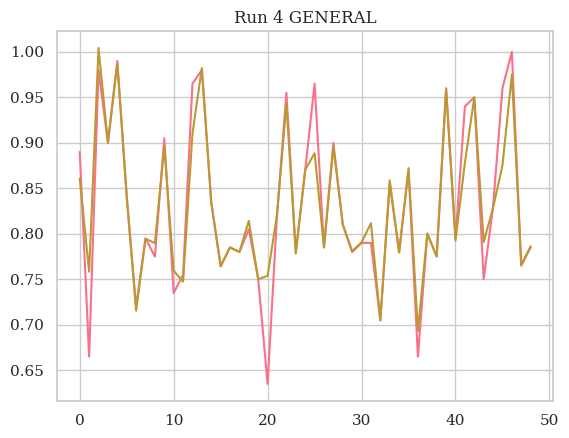

In [ ]:
plt.plot(Acc_subj_MTVAE)
plt.plot(prediccion_cercano)
plt.title('Run 4 GENERAL')

calculo de r y r2

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [ ]:
r =  pearsonr(prediccion_cercano,Acc_subj_MTVAE)[0]
r

0.9472973306076795

In [ ]:
r_2  = r2_score(prediccion_cercano,Acc_subj_MTVAE)
r_2

0.8307318330777167

In [ ]:
### R2
# Calcular el coeficiente de determinación $R^2$.
r2 = np.corrcoef(prediccion_cercano, Acc_subj_MTVAE)[0, 1]**2

# Imprimir los resultados.
print("El coeficiente de determinación $R^2$ es:", r2)

El coeficiente de determinación $R^2$ es: 0.8973694279562504


In [ ]:
from scipy.stats import ttest_rel

# Supongamos que 'y_real' son los valores reales y 'y_pred' son las predicciones del modelo

# Calcula la diferencia entre los valores reales y las predicciones
diferencia = [r - p for r, p in zip(Acc_subj_MTVAE,prediccion_cercano)]

# Realiza la prueba t de dos muestras relacionadas
t_stat, p_value = ttest_rel(Acc_subj_MTVAE, prediccion_cercano)

print(f'El valor p-valor es: {p_value}')

El valor p-valor es: 0.9587094912994513


## ENTRENAMOS REGRESOR POR GRUPOS

grupo 1

In [ ]:
grupo_1 =sorted([41,24,5,30,27,37,9,13,23,14,3,44,52])
grupo_2 = sorted([43,18,35,15,8,6,22,25,19,47,26,45,50,51])
grupo_3 = sorted([48,29,33,28,4,21,20,7,34,40,42,31,12,16,1,39,11,17,10,2,36,38])

len(grupo_1) + len(grupo_2) + len(grupo_3)

49

In [ ]:
### OBTENEMOS LOS DATOS UNICAMENTE DLE GRUPO
y_data_grupo = []
x_data_grupo = []

for i in range(len(y_data_runs)):

    if subjects[i] in grupo_3:
       y_data_grupo.append(y_data_runs[:,4][i]) ## agregamos run 0
       x_data_grupo.append(x_data_runs[:,4][i])

y_data_grupo = np.array(y_data_grupo)
x_data_grupo = np.array(x_data_grupo)
print(y_data_grupo.shape)
print(x_data_grupo.shape)

(22, 39)
(22, 39, 64, 256, 1)


In [ ]:
## COPIAMOS EL SET DE DATOS
## LISTA PARA AGREGAR LA PREDICCIÓN DEL SUJETO
for i in range(len(grupo_3)):

  ### ELIMINAMOS EL SUJETO DEL SET DE DATOS PARA ENTRENAR EL MODELO

  y_data_total_copy = np.copy(y_data_grupo)
  x_data_total_copy = np.copy(x_data_grupo)
  y_data_total_copy = np.delete(y_data_total_copy, i,axis=0)
  x_data_total_copy = np.delete(x_data_total_copy, i,axis=0)
  ### GENERAMOS EL SET DE DATOS DE ENTRENO Y VALIDACIÓN SIN TENER EN CUENTA EL SUJETO
  y_train = y_data_total_copy[0]
  x_train = x_data_total_copy[0]
  print(y_train.shape,x_train.shape,y_data_total_copy.shape,x_data_total_copy.shape)
  for a in range(1,len(y_data_total_copy)):
      y_train = np.concatenate([y_train,y_data_total_copy[a]])
      x_train = np.concatenate([x_train,x_data_total_copy[a]])
  X_train_, X_test_, y_train_, y_test_ = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
  #### generamos el modelo
  MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
  ### COMPILAMOS EL MODELO
  MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
  history = MODEL.fit(X_train_,[X_train_,y_train_],epochs= 60,verbose=0,validation_data=(X_test_, [X_test_,y_test_]),callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_group3_run4_'+str(i)+'.h5', save_best_only=True, monitor='val_out_activation_loss')])
  ### GRAFICAMOS LAS CURVAS DE OVERFITTING
  # loss = history.history['out_activation_mse']
  # val_loss = history.history['val_out_activation_mse']
  # epochs = range(1, len(loss) + 1)
  # # break
  # plt.plot(epochs, loss, 'y', label='Training loss')
  # plt.plot(epochs, val_loss, 'r', label='Validation loss')
  # plt.ylim([0, np.max(val_loss)])
  # plt.title('Curvas de perdida MSE ' +str(subjects[i]) )
  # save_file_path = os.path.join('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/', 'REGRESOR_MI_run4' +str(i+1)  + '.png')
  # plt.savefig(save_file_path)
  # plt.close()

(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 256, 1)
(39,) (39, 64, 256, 1) (21, 39) (21, 39, 64, 2

evaluamos rendimiento por grafica

In [ ]:
### OBTENEMOS LOS DATOS UNICAMENTE DLE GRUPO
y_data_grupo = []
x_data_grupo = []

for i in range(len(y_data_runs)):

    if subjects[i] in grupo_2:
       y_data_grupo.append(y_data_runs[:,0][i]) ## agregamos run 0
       x_data_grupo.append(x_data_runs[:,0][i])

y_data_grupo = np.array(y_data_grupo)
x_data_grupo = np.array(x_data_grupo)
print(y_data_grupo.shape)
print(x_data_grupo.shape)

(14, 40)
(14, 40, 64, 256, 1)


In [ ]:
### sacamos curva de sujetos
### OBTENEMOS LOS DATOS UNICAMENTE DLE GRUPO
Acc_grupo = []

for i in range(len(y_data_runs)):

    if subjects[i] in grupo_2:
       Acc_grupo.append(Acc_subj_MTVAE[i]) ## agregamos run 0

Acc_grupo = np.array(Acc_grupo)

In [ ]:
prediccion_cercano = []
for i in range(len(grupo_2)):
    ## ITERAMOS POR CADA SUJETO
    x_suject = x_data_grupo[i] ## OBTENEMOS LA INFORMACIÓN DEL SUJETO
    ## CARGAMOS EL MODELO
    MODEL = MTVAE_KL(Chans = 64, Samples = 256, dropoutRate = 0.5)
    MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
    MODEL.load_weights('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_group2_run0_'+str(i)+'.h5')
    ## HACEMOS LA PREDICCIÓN
    data = MODEL.predict(x_suject)[1][:,0]
    prediccion_cercano.append(Ec(data,Acc_grupo[i]))

2/2 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Run 1 Grupo 2')

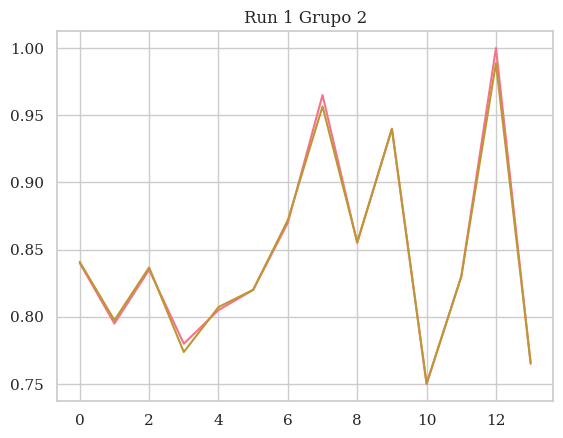

In [ ]:
plt.plot(Acc_grupo)
plt.plot(prediccion_cercano)
plt.title('Run 1 Grupo 2')

In [ ]:
### R2
# Calcular el coeficiente de determinación $R^2$.
r2 = np.corrcoef(prediccion_cercano, Acc_grupo)[0, 1]**2

# Calcula el Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(Acc_grupo, prediccion_cercano)

print(f"P-Value: {p_value}")
# Imprimir los resultados.
print("El coeficiente de determinación $R^2$ es:", r2)

P-Value: 0.9450520886884962
El coeficiente de determinación $R^2$ es: 0.9978558910400155


## REENTRENO REGRESOR TRANSFER LEARNING

cargamos los datos

In [ ]:
y_data_total_1 = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/y_regresor.pkl', 'rb'))
x_data_total_1 = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/x_regresor.pkl', 'rb'))
y_data_total_1 = np.array(y_data_total_1)
x_data_total_1 = np.array(x_data_total_1)

<ipython-input-148-2e04260f2c71>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data_total_1 = np.array(y_data_total_1)
<ipython-input-148-2e04260f2c71>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_total_1 = np.array(x_data_total_1)


In [ ]:
y_data_total_2 = pickle.load(open('/content/drive/MyDrive/EEG_DATA/MTVAE_SIN_SUJETO_DESPUES/y_regresor.pkl', 'rb'))
x_data_total_2 = pickle.load(open('/content/drive/MyDrive/EEG_DATA/MTVAE_SIN_SUJETO_DESPUES/x_regresor.pkl', 'rb'))
y_data_total_2 = np.array(y_data_total_2)
x_data_total_2 = np.array(x_data_total_2)

<ipython-input-149-527106ab94c9>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_data_total_2 = np.array(y_data_total_2)
<ipython-input-149-527106ab94c9>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_total_2 = np.array(x_data_total_2)


In [ ]:
x_data_total = []
for i in range(0,len(y_data_total_1)):
   x_data_total.append(np.concatenate([x_data_total_1[i],x_data_total_2[i]],axis=2))

y_data_total = y_data_total_1
x_data_total = np.array(x_data_total)

<ipython-input-150-61aeda96112e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_total = np.array(x_data_total)


DEFINIMOS EL MODELO

In [ ]:
y_data_total.shape

(49,)

In [ ]:
x_data_total[0].shape

(199, 64, 512, 1)

In [ ]:
### ELIMINAMOS EL SUJETO DEL SET DE DATOS PARA ENTRENAR EL MODELO

y_data_total_copy = np.copy(y_data_total)
x_data_total_copy = np.copy(x_data_total)
### GENERAMOS EL SET DE DATOS DE ENTRENO Y VALIDACIÓN SIN TENER EN CUENTA EL SUJETO
y_train = y_data_total_copy[0]
x_train = x_data_total_copy[0]

for a in range(1,len(y_data_total_copy)):
    y_train = np.concatenate([y_train,y_data_total_copy[a]])
    x_train = np.concatenate([x_train,x_data_total_copy[a]])
X_train_, X_test_, y_train_, y_test_ = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
print(y_train_.shape,X_train_.shape,y_test_.shape,X_test_.shape)
#### generamos el modelo
MODEL = MTVAE_KL(Chans = 64, Samples = 448, dropoutRate = 0.5)
### COMPILAMOS EL MODELO
MODEL.compile(optimizer='adam',loss=['mse','mse'], metrics= ['mse'])
history = MODEL.fit(X_train_[:,:,:448],[X_train_[:,:,:448],y_train_],epochs= 60,verbose=1,validation_data=(X_test_[:,:,:448], [X_test_[:,:,:448],y_test_]),callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_transfer_learning_regresor_'+'.h5', save_best_only=True, monitor='val_out_activation_loss')])

(7802,) (7802, 64, 512, 1) (1951,) (1951, 64, 512, 1)
Epoch 1/60
244/244 [==============================] - 7s 15ms/step - loss: 1.1016 - conv2d_transpose_2192_loss: 1.0320 - out_activation_loss: 0.0566 - conv2d_transpose_2192_mse: 1.0320 - out_activation_mse: 0.0566 - val_loss: 1.0547 - val_conv2d_transpose_2192_loss: 1.0379 - val_out_activation_loss: 0.0165 - val_conv2d_transpose_2192_mse: 1.0379 - val_out_activation_mse: 0.0165
Epoch 2/60
244/244 [==============================] - 3s 11ms/step - loss: 1.0504 - conv2d_transpose_2192_loss: 1.0319 - out_activation_loss: 0.0167 - conv2d_transpose_2192_mse: 1.0319 - out_activation_mse: 0.0167 - val_loss: 1.0452 - val_conv2d_transpose_2192_loss: 1.0380 - val_out_activation_loss: 0.0072 - val_conv2d_transpose_2192_mse: 1.0380 - val_out_activation_mse: 0.0072
Epoch 3/60
244/244 [==============================] - 3s 12ms/step - loss: 1.0427 - conv2d_transpose_2192_loss: 1.0319 - out_activation_loss: 0.0106 - conv2d_transpose_2192_mse: 1.0319

##Transfer Learning

In [ ]:
### Cargamos los datos para el modelo de clasificación
y_data_total = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/y_clasification.pkl', 'rb'))
x_data_total = pickle.load(open('/content/drive/MyDrive/EEG_DATA/GIGA_DATASET/x_clasification.pkl', 'rb'))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

class reparametrize(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eta = tf.random.normal(tf.shape(log_var))
        sigma = tf.math.exp(log_var / 2)
        return  mean + sigma * eta

def MTVAE_CLASS(nb_classes, Chans = 22, Samples = 250, dropoutRate = 0.5, l1 = 0, l2 = 0,block1 = None):

    filters      = (1,40)
    strid        = (1,15)
    pool         = (1,75)
    bias_spatial = True
    input_main   = Input((Chans, Samples, 1))


    mu           = Dense(40,name='mu')(block1.output)
    log_var      = Dense(40,name='log_var')(block1.output)
    codings      = reparametrize(name='Code')([mu, log_var])

    ConvC        = Conv2D(nb_classes, (1, block1.output.shape[2]),kernel_regularizer=l1_l2(l1=l1,l2=l2),kernel_constraint = max_norm(0.5, axis=(0,1,2)),name='ouput')(block1.output)
    flat          = Flatten(name='output')(ConvC)
    softmax      = Activation('softmax',name='out_activation')(flat)

    block2       = Conv2DTranspose(40, pool,strides=strid,activation='tanh', kernel_regularizer=l1_l2(l1=l1,l2=l2),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(codings)
    block2       = Resizing(block2.shape[1], 205)(block2) ## ACT1.SHAPE
    block2       = Conv2DTranspose(40, (Chans, 1), use_bias=bias_spatial, kernel_regularizer=l1_l2(l1=l1,l2=l2),
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block2       = Conv2DTranspose(1, filters,strides=(1,2),
                                 input_shape=(Chans, Samples, 1),kernel_regularizer=l1_l2(l1=l1,l2=l2),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)

    model = Model(inputs=block1.input, outputs=[block2,softmax])


    var_flat      = Flatten()(log_var)
    mu_flat       = Flatten()(mu)

    KL = -0.5 * tf.keras.backend.sum( 1 + var_flat - tf.keras.backend.exp(var_flat) - tf.keras.backend.square(mu_flat),axis=-1)
    model.add_loss(tf.keras.backend.mean(KL)/var_flat.shape[-1])#Chans*Samples)
    return model

entrenamos

In [ ]:
from src.prediction.Model_Control.Global_Class.Global_Class import ModelControl
from src.prediction.Model_Control.Global_Class.Global_Class import DatasetControl

In [ ]:
acc_mtvae_regresor = []
#### OBTENEMOS LOS CALLBACKS NECESARIOS
callbacks_names = {'early_stopping_train1':'early_stopping','checkpoint_train1':'checkpoint',
                   'early_stopping_train2':'early_stopping','checkpoint_train2':'checkpoint',
                   'early_stopping_train3':'early_stopping','checkpoint_train3':'checkpoint',
                   'early_stopping_train4':'early_stopping','checkpoint_train4':'checkpoint'}

In [ ]:
len(y_data_total)

46

In [ ]:
x_data_total[0].shape

(200, 64, 448, 1)

In [ ]:
for i in range(0,len(y_data_total)):

    ####### SUJETO ###########
    print("SUJETO : ",subjects[i])

    #### CARGAMOS LOS DATOS DE ENTRENAMIENTO
    x_train = x_data_total[i]
    y_train = y_data_total[i]

    #### CARGAMOS EL MODELO
    ### CARGAMOS LA BASE DE DATOS BCI2A Y EEGNET
    MODEL = MTVAE_KL(Chans = 64, Samples = 448, dropoutRate = 0.5)
    ### COMPILAMOS EL MODELO
    filepath = '/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/model_transfer_learning_regresor_'+'.h5'
    MODEL.load_weights(filepath)
    layer_name='bottleneck'
    ENCODER = Model(inputs=MODEL.input,
                                  outputs=MODEL.get_layer(layer_name).output)
    print("ENCODER: ",ENCODER.summary())
    ### CARGAMOS LA BASE DE DATOS BCI2A Y EEGNET
    MODEL_CLASS = MTVAE_CLASS(Chans = 64, Samples = 448, dropoutRate = 0.5,nb_classes =2,block1 = ENCODER)

    ### COMPILAMOS EL MODELO
    # Congelar las capas del modelo original hasta la capa deseada (por ejemplo, 'mu')

    # Imprimir la estructura del nuevo modelo después de congelar
    MODEL_CLASS.compile(optimizer='adam',loss=['mse','categorical_crossentropy'],metrics = ['accuracy'])

    ### ENTRENAMOS EL MODELO
    validation = 'lawhern2018'
      # ## '/content/drive/MyDrive/EEG_DATA/EEGNET_RESULTS/EEGNET_ALL_RUNS_BI_GIGA/'+
    call_args = [
          {'monitor':'val_out_activation_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
          {'filepath':'/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/'+'checkpoint1_'+str(subjects[i]),'save_format':'tf','monitor':'val_out_activation_accuracy','verbose':1,'save_best_only':True,'save_weights_only':True},
          {'monitor':'val_out_activation_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
          {'filepath':'/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/'+'checkpoint2_'+str(subjects[i]),'save_format':'tf','monitor':'val_out_activation_accuracy','verbose':1,'save_best_only':True,'save_weights_only':True},
          {'monitor':'val_out_activation_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
          {'filepath':'/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/'+'checkpoint3_'+str(subjects[i]),'save_format':'tf','monitor':'val_out_activation_accuracy','verbose':1,'save_best_only':True,'save_weights_only':True},
          {'monitor':'val_out_activation_accuracy','patience':100,'min_delta':0.001,'mode':'max','verbose':1,'restore_best_weights':False},
          {'filepath':'/content/drive/MyDrive/EEG_DATA/MTVAE_REGRESORxRuns/'+'checkpoint4_'+str(subjects[i]),'save_format':'tf','monitor':'val_out_activation_accuracy','verbose':1,'save_best_only':True,'save_weights_only':True},
      ]

    modelControl = ModelControl()
    print(MODEL_CLASS.summary())

    History,acc_model  = modelControl.train_model(Indice = 1,Model = MODEL_CLASS,X_train=x_train,Y_train=[x_train,y_train],x_val=x_train,y_val=[x_train,y_train],callbacks_names = callbacks_names,call_args =call_args,validation_mode = validation, batch_size =16,epochs = 800,verbose =0,autoencoder=True)

    ### OBTENEMOS EL ACCURACY
    print("ACCURACY PER SUBJECT: ",acc_model)
    acc_mtvae_regresor.append(acc_model)

Se han truncado las últimas 5000 líneas del flujo de salida.

Epoch 53: val_out_activation_accuracy did not improve from 0.97778

Epoch 54: val_out_activation_accuracy did not improve from 0.97778

Epoch 55: val_out_activation_accuracy did not improve from 0.97778

Epoch 56: val_out_activation_accuracy did not improve from 0.97778

Epoch 57: val_out_activation_accuracy did not improve from 0.97778

Epoch 58: val_out_activation_accuracy did not improve from 0.97778

Epoch 59: val_out_activation_accuracy did not improve from 0.97778

Epoch 60: val_out_activation_accuracy did not improve from 0.97778

Epoch 61: val_out_activation_accuracy did not improve from 0.97778

Epoch 62: val_out_activation_accuracy did not improve from 0.97778

Epoch 63: val_out_activation_accuracy did not improve from 0.97778

Epoch 64: val_out_activation_accuracy did not improve from 0.97778

Epoch 65: val_out_activation_accuracy did not improve from 0.97778

Epoch 66: val_out_activation_accuracy did not improve 

In [ ]:
ACC_MTVAE =          [89.0,66.5,98.0,90.0,99.0,84.0,72.0,79.5,77.5,90.5,73.5,75.5,96.5,98.0,83.5,76.5,78.5,78.0,80.5,75.0,63.5,82.0,95.5,78.0,87.0,96.5,78.5,90.0,81.0,78.0,79.0,79.0,70.5,85.5,78.0,87.0,66.5,80.0,77.5,96.0,79.5,94.0,95.0,75.0,83.0,96.0,100.0,76.5,78.5]

In [ ]:
acc_mtvae_regresor = [89.0,74.5,98.0,87.0,98.5,84.5,85.0,84.0,85.0,92.5,81.5,88.5,93.0,96.5,86.0,88.0,83.5,79.5,84.5,85.0,71.5,86.5,90.0,83.0,87.0,97.5,88.5,86.0,82.5,78.0,83.0,75.5,78.0,82.5,81.0,88.0,74.5,82.0,87.5,94.0,87.5,94.5,94.0,84.0,88.5,96.0,98.0,86.0,86.4]

graficamos los resultados

Text(0.5, 1.0, 'MTVAE MODEL STANDAR VS REGRESOR')

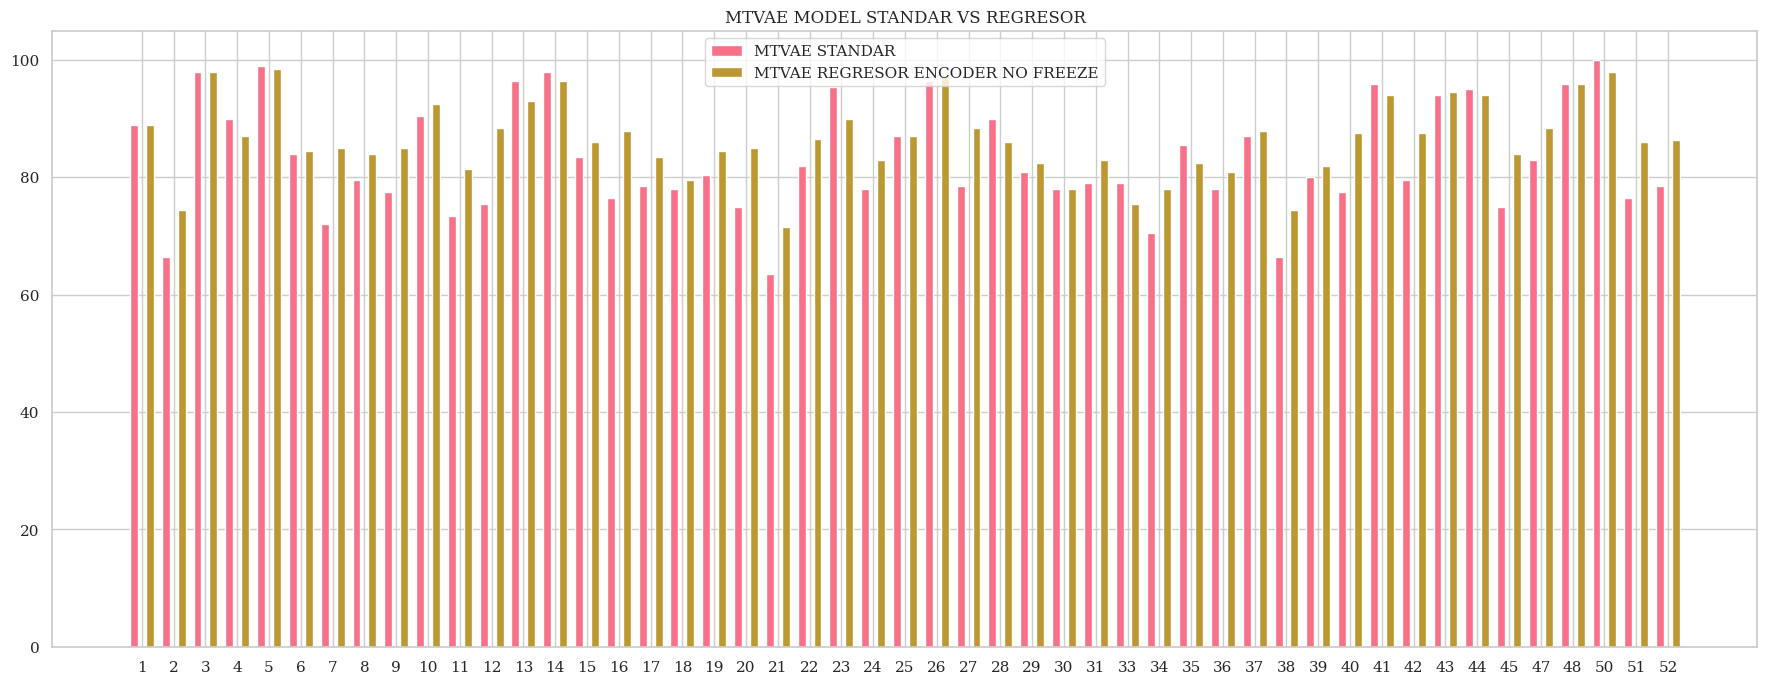

In [ ]:
# Configurar el ancho de las barras
ancho_barra = 0.25

# Calcular las posiciones para las barras
posiciones_1 = np.arange(len(subjects))
posiciones_2 = posiciones_1 + ancho_barra
posiciones_3 = posiciones_2 + ancho_barra

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(22, 8))

# Dibujar -las barras
ax.bar(posiciones_1, ACC_MTVAE, width=ancho_barra, label='MTVAE STANDAR')
ax.bar(posiciones_3, acc_mtvae_regresor, width=ancho_barra, label='MTVAE REGRESOR ENCODER NO FREEZE')

# Configurar el eje x
ax.set_xticks(posiciones_2)
ax.set_xticklabels(subjects)
plt.legend()
plt.title('MTVAE MODEL STANDAR VS REGRESOR')

In [ ]:
### ORDENAMOS LA LISTA SEGUN LOS ACCURACY
pares_ordenados = sorted(zip(ACC_MTVAE, subjects), reverse=True)
pares_ordenados_2 = sorted(zip(ACC_MTVAE, acc_mtvae_regresor), reverse=True)
acc_subj_MTVAE_ORDENADA, subjects_str_ORDENADA = zip(*pares_ordenados)
acc_subj_MTVAE_ORDENADA, regresor_ORDENADA = zip(*pares_ordenados_2)

Text(0.5, 1.0, 'MTVAE MODEL STANDAR VS REGRESOR')

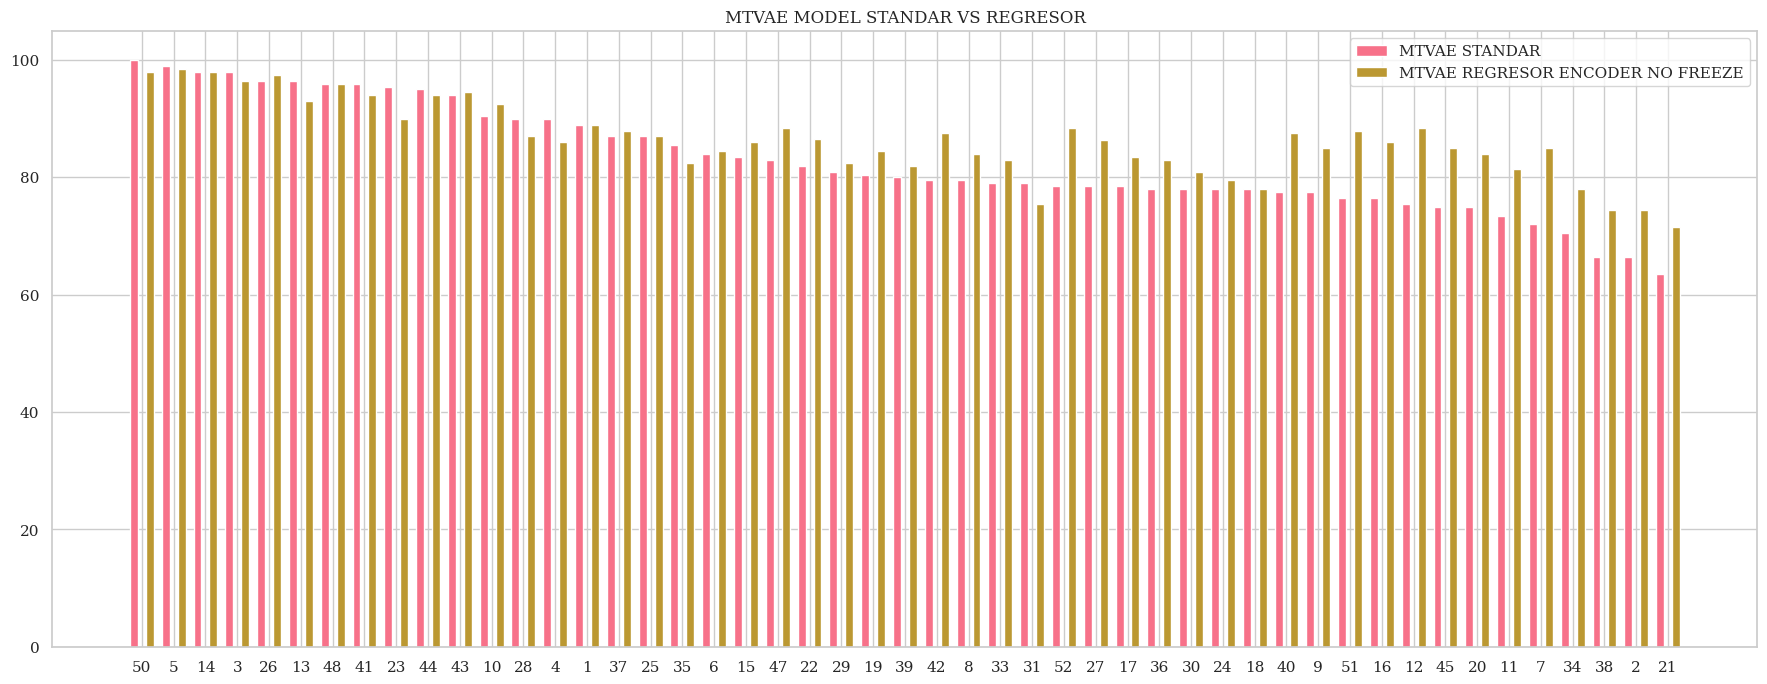

In [ ]:
# Configurar el ancho de las barras
ancho_barra = 0.25

# Calcular las posiciones para las barras
posiciones_1 = np.arange(len(subjects_str_ORDENADA))
posiciones_2 = posiciones_1 + ancho_barra
posiciones_3 = posiciones_2 + ancho_barra

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(22, 8))

# Dibujar -las barras
ax.bar(posiciones_1, acc_subj_MTVAE_ORDENADA, width=ancho_barra, label='MTVAE STANDAR')
ax.bar(posiciones_3, regresor_ORDENADA , width=ancho_barra, label='MTVAE REGRESOR ENCODER NO FREEZE')

# Configurar el eje x
ax.set_xticks(posiciones_2)
ax.set_xticklabels(subjects_str_ORDENADA)
plt.legend()
plt.title('MTVAE MODEL STANDAR VS REGRESOR')